In [1]:
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import ast
# import Counter
from collections import Counter

from math import ceil
from scipy.special import factorial
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
base_dir = os.getenv("SCRATCH_DIR")
# base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
behav_dir = os.path.join(data_dir, "behav")
stimuli_dir = os.path.join(data_dir, "stimuli")

In [3]:
df_1 = pd.read_csv(os.path.join(behav_dir, "prettymouth1.csv"))
df_2a = pd.read_csv(os.path.join(behav_dir, "prettymouth2a.csv"))
df_2b = pd.read_csv(os.path.join(behav_dir, "prettymouth2b.csv"))
df_2_postsurvey = pd.read_csv(os.path.join(behav_dir, "prettymouth2_postsurvey.csv"))
df_2_postsurvey = df_2_postsurvey.iloc[2:]

In [9]:
df1 = df_1[~df_1["key_resp_2.rt"].isna()]
df_2a_reponse = df_2a[~df_2a["key_resp_2.rt"].isna()]
df_2b_reponse = df_2b[~df_2b["key_resp_2.rt"].isna()]

In [7]:
df2a = df_2a_reponse[df_2a_reponse["participant"].isin(df_2_postsurvey["participant"])]
df2b = df_2b_reponse[df_2b_reponse["participant"].isin(df_2_postsurvey["participant"])]
df2a_ps = df_2_postsurvey[df_2_postsurvey["participant"].isin(df2a["participant"])]
df2b_ps = df_2_postsurvey[df_2_postsurvey["participant"].isin(df2b["participant"])]
print(f"df2a has {df2a.shape[0]} rows")
print(f"df2b has {df2b.shape[0]} rows")
print(f"df2a_ps has {df2a_ps.shape[0]} rows")
print(f"df2b_ps has {df2b_ps.shape[0]} rows")

df2a has 63 rows
df2b has 59 rows
df2a_ps has 63 rows
df2b_ps has 59 rows


In [8]:
def plot_scatter(df, group):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df_exploded = df[['key_resp_2.rt', 'participant']].explode('key_resp_2.rt')
    participants = df_exploded['participant'].unique()

    # Assign a unique y-value (level) for each participant
    participant_levels = {participant: i for i, participant in enumerate(participants, start=1)}

    # Create a new figure for the adjusted plot
    plt.figure(figsize=(12, 8))

    # Iterate over each participant to plot their reaction times
    for participant, level in participant_levels.items():
        # Get the reaction times for this participant
        participant_data = df_exploded[df_exploded['participant'] == participant]
        reaction_times = participant_data['key_resp_2.rt']
        
        # Plot each reaction time for this participant at their assigned y-level
        plt.scatter(reaction_times, [level] * len(reaction_times), label=participant, s=10)

    # Adjust the y-axis to show participant labels instead of numeric levels
    # plt.yticks(list(participant_levels.values()), list(participant_levels.keys()))
    plt.ylabel('Participant ID')
    plt.xlabel('Seconds')
    plt.title(f'{group}')
    # plt.legend(title='Participant ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

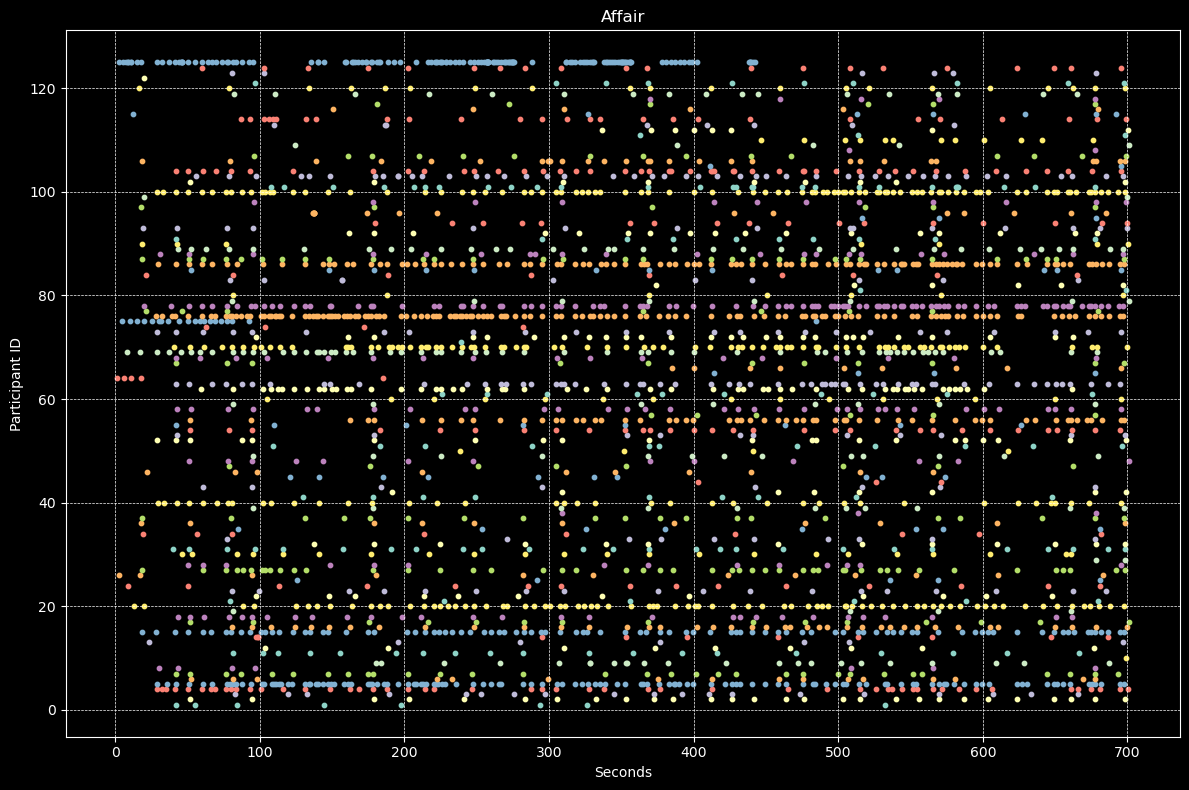

In [10]:
plot_scatter(df1, "Affair")

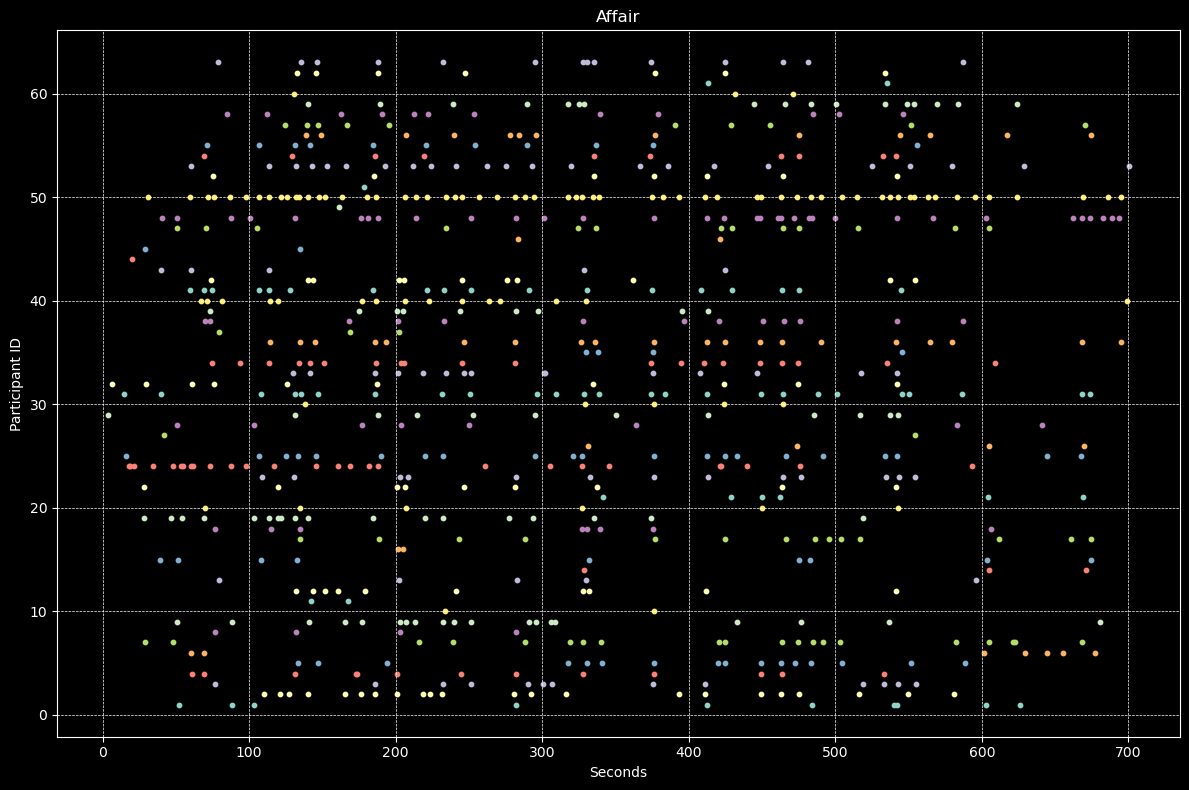

In [11]:
plot_scatter(df2a, "Affair")

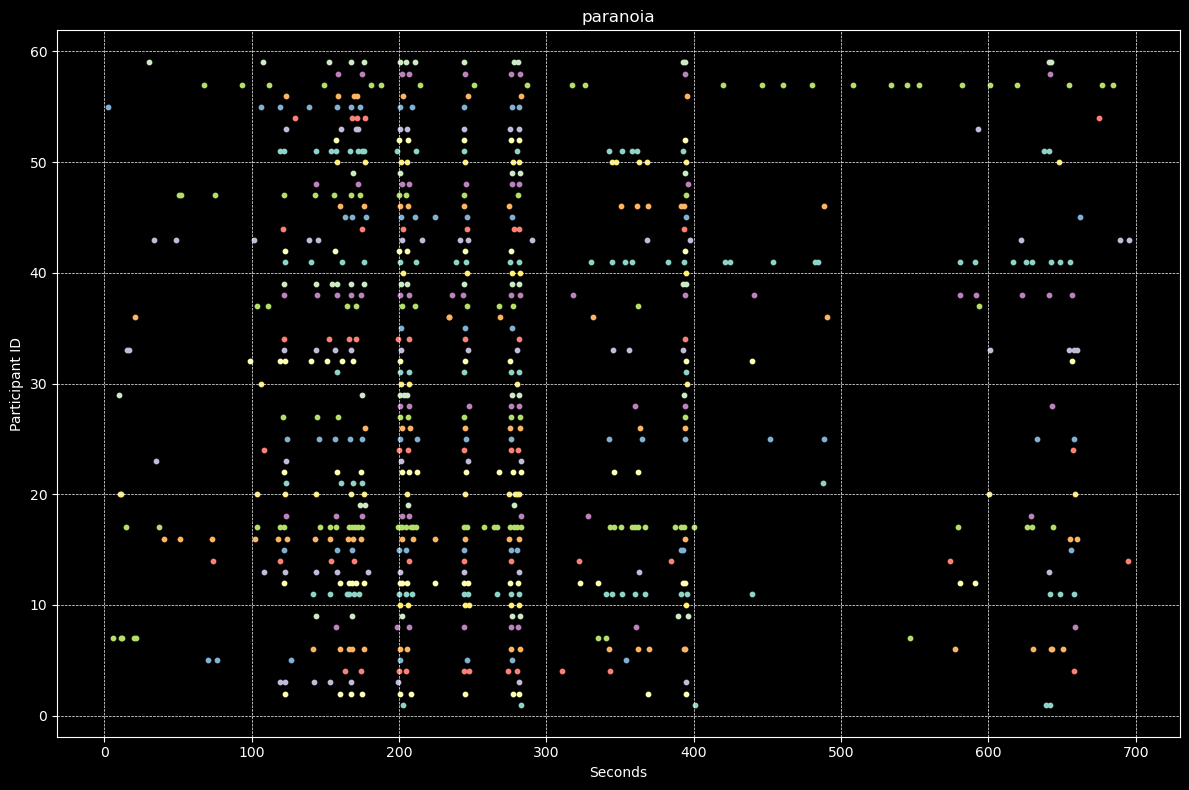

In [12]:
plot_scatter(df2b, "paranoia")

In [13]:
def seconds2TRs(resp_seconds):
    resp_seconds = np.array(resp_seconds)
    resp_TRs = np.ceil(resp_seconds / 1.5)
    resp_TRs = np.unique(resp_TRs)
    return resp_TRs

In [14]:
def get_agreement(df):
    df['key_resp_2.rt'] = df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['key_resp_2.TR'] = df['key_resp_2.rt'].apply(lambda x: np.around(x, decimals=3))
    df['key_resp_2.TR'] = df['key_resp_2.TR'].apply(seconds2TRs)
    response_col = 'key_resp_2.TR'
    unit = 'TR'
    all_responses = []
    for i, row in enumerate(df[response_col]):
        # Skip over None or NaN values
        if row is None or (isinstance(row, float) and np.isnan(row)):
            continue
        all_responses.extend(row)
    # Count the occurrences of each unique element
    response_counts = Counter(all_responses)
    # Create a new DataFrame
    agreement_df = pd.DataFrame(list(response_counts.items()), columns=[unit, 'count'])
    # drop nan based on TR
    agreement_df = agreement_df.dropna(subset=[unit])
    # Sort by TR for better readability
    agreement_df = agreement_df.sort_values(by=unit).reset_index(drop=True)
    agreement_df['agreement'] = agreement_df['count'] / df.shape[0]
    # remove the first 14 TRs/21s and the last 3 TRs
    if unit == 'TR':
        agreement_df = agreement_df[(agreement_df[unit] > 14)&(agreement_df[unit] < 467)]
    elif unit == 'second':
        agreement_df = agreement_df[(agreement_df[unit] > 21)&(agreement_df[unit] < 699)]
    else:
        print("Please enter a valid unit: TR or second")
    # reset index
    agreement_df = agreement_df.reset_index(drop=True)
    return agreement_df

In [15]:
agree_TR_df1 = get_agreement(df1)
agree_TR_df2a = get_agreement(df2a)
agree_TR_df2b = get_agreement(df2b)

In [16]:
agree_TR_df1

,TR,count,agreement
0,15.0,3,0.023810
1,16.0,1,0.007937
2,18.0,1,0.007937
3,19.0,2,0.015873
4,20.0,9,0.071429
...,...,...,...
424,462.0,2,0.015873
425,463.0,3,0.023810
426,464.0,19,0.150794
427,465.0,11,0.087302
